Author: Evan Yip <br>
Purpose: Generating numerical distribution plots and computing Normative ODI metrics <br>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

##### Set the current working directory to the root of your project
os.chdir("/Users/evan/Documents/School/MSDS/msds-capstone/vm-spinal-risk/vm-spinal-risk/")

In [2]:
# Reading in the data
odi_df = pd.read_csv('./data/data_processed/all_risk_processed.csv')
census_df = pd.read_excel('./data/data_raw/nc-est2022-agesex.xlsx', header=4)
odi_df = odi_df.rename(columns={'ADI_NATRANK':'adi_score'})

In [3]:
# Cleaning up the Census data
census_2022 = census_df[['Unnamed: 0', 'Both Sexes.3']].iloc[:19, :]
census_2022.columns = ['age_group', 'population']

groups = {
    '<20s': ['.Under 5 years', '.5 to 9 years', '.10 to 14 years', '.15 to 19 years'],
    '20s': ['.20 to 24 years', '.25 to 29 years'],
    '20s': ['.20 to 24 years', '.25 to 29 years'],
    '30s': ['.30 to 34 years', '.35 to 39 years'],
    '40s': ['.40 to 44 years', '.45 to 49 years'],
    '50s': ['.50 to 54 years', '.55 to 59 years'],
    '60s': ['.60 to 64 years', '.65 to 69 years'],
    '70s': ['.70 to 74 years', '.75 to 79 years'],
    '80s': ['.80 to 84 years', '.85 years and over']
}

census_2022_clean = {'age_group':[], 'population':[]}
for age_group in groups.keys():
    pop = census_2022[census_2022['age_group'].isin(groups[age_group])]['population'].sum()
    census_2022_clean['age_group'].append(age_group)
    census_2022_clean['population'].append(pop)

census_2022_clean_df = pd.DataFrame(census_2022_clean)

total = census_2022_clean_df['population'].sum()
# Compute percentage weights
census_2022_clean_df['weights'] = census_2022_clean_df['population'] / total
census_2022_clean_df


,age_group,population,weights
0,<20s,81073179.0,0.243253
1,20s,44898943.0,0.134715
2,30s,45576085.0,0.136747
3,40s,41051514.0,0.123171
4,50s,41774561.0,0.125341
5,60s,39749845.0,0.119266
6,70s,26018017.0,0.078065
7,80s,13145413.0,0.039442


In [4]:
# Removing incomplete data
odi_quality_df = odi_df[odi_df['risk_1_timestamp'] != '[not completed]']

In [5]:
adi_scores = odi_quality_df.copy().adi_score
odi_quality_df['adi_score'] = pd.to_numeric(adi_scores, errors='coerce')

rename_cols = {
 'age': 'Age',
 'sex': 'Sex',
 'height_m': 'Height (m)',
 'weight_kg': 'Weight (kg)',
 'bmi':'BMI',
 'age_range':'Age range',
 'adi_score':'ADI',
 'odi_final':'ODI'}
odi_rename = odi_quality_df.rename(columns=rename_cols)
odi_rename = odi_rename.replace(to_replace='<20', value='0-20')

Average BMI across male and females

In [6]:
adults = odi_rename[odi_rename['Age'] >= 20]
adults[['Sex', 'BMI']].groupby(by='Sex').mean()

,BMI
Sex,
1,26.419954
2,27.110922
3,28.368252
4,19.621460


Overall BMI across all adults

In [7]:
adults[['BMI']].mean()

BMI    26.763664
dtype: float64

BMI across Sexes

In [8]:
odi_rename[['Sex', 'BMI']].groupby(by='Sex').mean()

,BMI
Sex,
1,26.398593
2,27.089053
3,28.368252
4,19.621460


Computing the Normative ODI (reweighted using the census age group population counts)

In [9]:
median_odi = odi_rename[['Age range', 'ODI']].groupby('Age range').median().reset_index()
median_odi['weighted_odi'] = median_odi['ODI'] * census_2022_clean_df['weights']
print("Normative Median ODI (Reweighted using census counts):", median_odi['weighted_odi'].sum())

Normative Median ODI (Reweighted using census counts): 27.495631080520656


In [10]:
from tableone import TableOne

## Create an instance of TableOne with the input arguments
columns = [
       'Age',
       'Sex', 
       'Height (m)', 
       'Weight (kg)', 
       'BMI',
       # 'how_physically_demanding_i', 
       # 'have_you_ever_experienced',
       # 'how_have_you_addressed_add', 
       'Age range',
       'ADI', 
       'ODI']
nonnormal = ['ODI', 'Weight (kg)', 'ADI']
categorical = ['Age range', 'Sex']
mytable = TableOne(odi_rename, columns=columns, categorical=categorical, nonnormal=nonnormal)

mytable
## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))

|                             |       | Missing   | Overall          |
|-----------------------------|-------|-----------|------------------|
| n                           |       |           | 799              |
| Age, mean (SD)              |       | 0         | 53.5 (19.6)      |
| Sex, n (%)                  | 1     | 0         | 384 (48.1)       |
|                             | 2     |           | 411 (51.4)       |
|                             | 3     |           | 2 (0.3)          |
|                             | 4     |           | 2 (0.3)          |
| Height (m), mean (SD)       |       | 0         | 1.7 (0.1)        |
| Weight (kg), median [Q1,Q3] |       | 0         | 77.6 [66.2,91.2] |
| BMI, mean (SD)              |       | 0         | 26.7 (6.4)       |
| Age range, n (%)            | 0-20  | 0         | 5 (0.6)          |
|                             | 20-30 |           | 114 (14.3)       |
|                             | 30-40 |           | 121 (15.1)       |
|     

Numerical Distribution plots

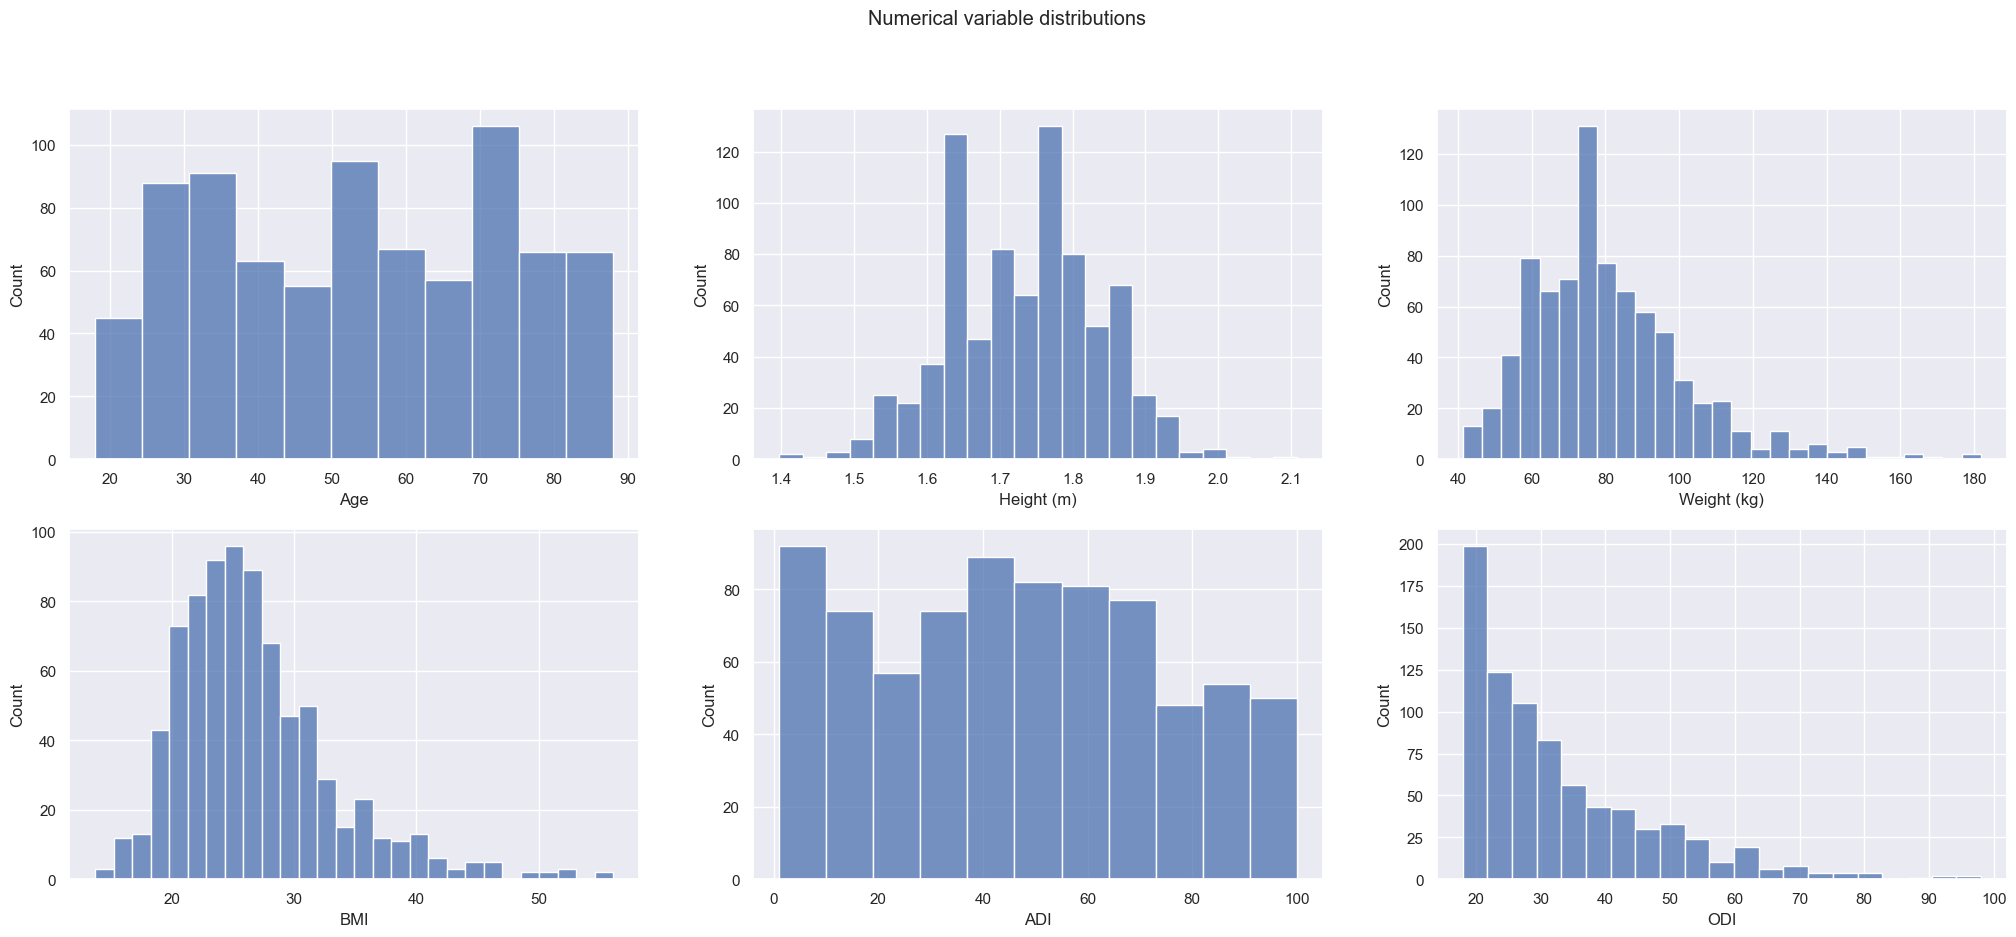

In [11]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

sns.histplot(odi_quality_df['age'], ax=axes[0])
sns.histplot(odi_quality_df['height_m'], ax=axes[1])
sns.histplot(odi_quality_df['weight_kg'], ax=axes[2])
sns.histplot(odi_quality_df['bmi'], ax=axes[3])
sns.histplot(odi_quality_df['adi_score'], ax=axes[4])
sns.histplot(odi_quality_df['odi_final'], ax=axes[5])
plt.suptitle("Numerical variable distributions")
axes[0].set_xlabel("Age")
axes[1].set_xlabel("Height (m)")
axes[2].set_xlabel("Weight (kg)")
axes[3].set_xlabel("BMI")
axes[4].set_xlabel("ADI")
axes[5].set_xlabel("ODI")
plt.show()

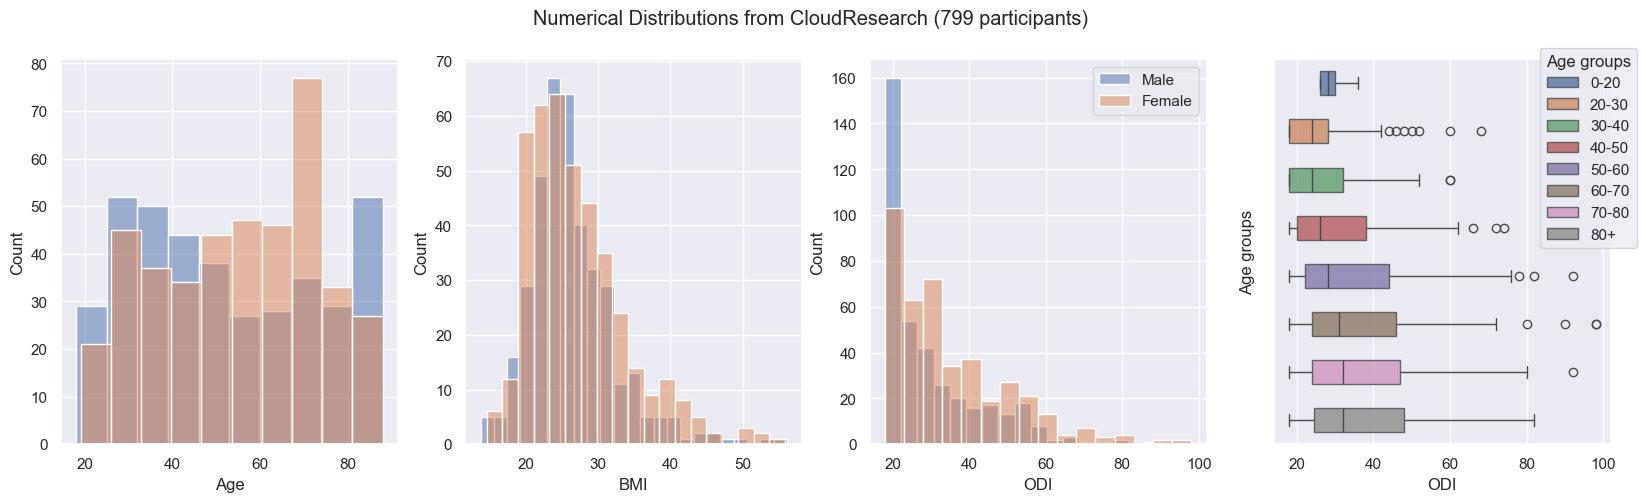

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
sns.histplot(odi_rename[odi_rename['Sex'] == 1]['Age'], ax=axes[0], label='Male', alpha=0.5)
sns.histplot(odi_rename[odi_rename['Sex'] == 2]['Age'], ax=axes[0], label='Female', alpha=0.5)
sns.histplot(odi_rename[odi_rename['Sex'] == 1]['BMI'], ax=axes[1], label='Male', alpha=0.5)
sns.histplot(odi_rename[odi_rename['Sex'] == 2]['BMI'], ax=axes[1], label='Female', alpha=0.5)
sns.histplot(odi_rename[odi_rename['Sex'] == 1]['ODI'], ax=axes[2], label='Male', alpha=0.5)
sns.histplot(odi_rename[odi_rename['Sex'] == 2]['ODI'], ax=axes[2], label='Female', alpha=0.5)
sns.boxplot(odi_rename.sort_values('Age range'), x='ODI', hue='Age range', width=1, gap=0.5, ax=axes[3], boxprops=dict(alpha=.8))
# plt.title("ODI Across Age Groups")
axes[3].legend(title="Age groups", bbox_to_anchor=(1.1, 1.05))
axes[3].set_ylabel("Age groups")
axes[2].set_xlabel("ODI")
axes[2].legend()
plt.suptitle('Numerical Distributions from CloudResearch (799 participants)')
plt.show()

Stratified across Sex

In [13]:
# ODI
nonnormal = ['odi_final']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['sex'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable

|                           |       | Missing   | Overall          | 1                | 2                | 3                | 4                | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|------------------|------------------|-----------|
| n                         |       |           | 799              | 384              | 411              | 2                | 2                |           |
| odi_final, median [Q1,Q3] |       | 0         | 28.0 [22.0,40.0] | 26.0 [20.0,36.0] | 30.0 [23.0,42.0] | 28.0 [23.0,33.0] | 29.0 [26.5,31.5] | <0.001    |
| age_range, n (%)          | 20-30 | 0         | 114 (14.3)       | 62 (16.1)        | 51 (12.4)        |                  | 1 (50.0)         | 0.003     |
|                           | 30-40 |           | 121 (15.1)       | 71 (18.5)        | 50 (12.2)        |                  |                  |           |
|                           | 40-50 |           | 102 (12.

Stratified across age groups

In [14]:
# ODI
nonnormal = ['odi_final']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['age_range'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable.tabulate(tablefmt=)
mytable

|                           |       | Missing   | Overall          | 20-30            | 30-40            | 40-50            | 50-60            | 60-70            | 70-80            | 80+              | <20              | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|-----------|
| n                         |       |           | 799              | 114              | 121              | 102              | 120              | 112              | 107              | 118              | 5                |           |
| odi_final, median [Q1,Q3] |       | 0         | 28.0 [22.0,40.0] | 24.0 [18.0,28.0] | 24.0 [18.0,32.0] | 26.0 [20.0,38.0] | 28.0 [22.0,44.0] | 31.0 [24.0,46.0] | 32.0 [24.0,47.0] | 32.0 [24.5,48.0] | 28.0 [26.0,30.0] | <0.001    |
| age_range, n (%)          | 20-30 | 0         | 114 (14.3)       |

Grouped by age_range                                                                                                                                                                          
                                             Missing           Overall             20-30             30-40             40-50             50-60             60-70             70-80               80+               <20 P-Value
n                                                                  799               114               121               102               120               112               107               118                 5        
odi_final, median [Q1,Q3]                          0  28.0 [22.0,40.0]  24.0 [18.0,28.0]  24.0 [18.0,32.0]  26.0 [20.0,38.0]  28.0 [22.0,44.0]  31.0 [24.0,46.0]  32.0 [24.0,47.0]  32.0 [24.5,48.0]  28.0 [26.0,30.0]  <0.001
age_range, n (%)          20-30                    0        114 (14.3)       114 (100.0)                                                                                                                                <0.001
                          30-40                             121 (15.1)                         121 (100.0)                                                                                                                    
                          40-50                             102 (12.8)                                           102 (100.0)                                                                                                  
                          50-60                             120 (15.0)                                                             120 (100.0)                                                                                
                          60-70                             112 (14.0)                                                                               112 (100.0)                                                              
                          70-80                             107 (13.4)                                                                                                 107 (100.0)                                            
                          80+                               118 (14.8)                                                                                                                   118 (100.0)                          
                          <20                                  5 (0.6)                                                                                                                                       5 (100.0)        
sex, n (%)                1                        0        384 (48.1)         62 (54.4)         71 (58.7)         56 (54.9)         48 (40.0)         40 (35.7)         36 (33.6)         68 (57.6)          3 (60.0)   0.003
                          2                                 411 (51.4)         51 (44.7)         50 (41.3)         45 (44.1)         71 (59.2)         72 (64.3)         70 (65.4)         50 (42.4)          2 (40.0)        
                          4                                    2 (0.3)           1 (0.9)                             1 (1.0)                                                                                                  
                          3                                    2 (0.3)                                                                 1 (0.8)                             1 (0.9)                                            
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: age_range, sex.

Correlations plots

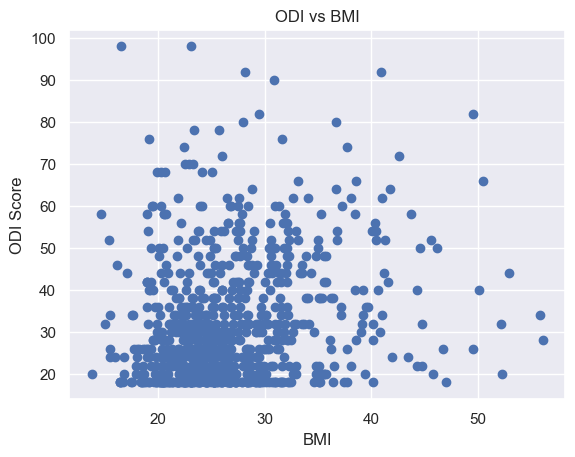

In [15]:
fig, ax = plt.subplots()
ax.plot(odi_quality_df['bmi'], odi_quality_df['odi_final'], 'o')
ax.set_ylabel('ODI Score')
ax.set_xlabel('BMI')
ax.set_title("ODI vs BMI")
plt.show()

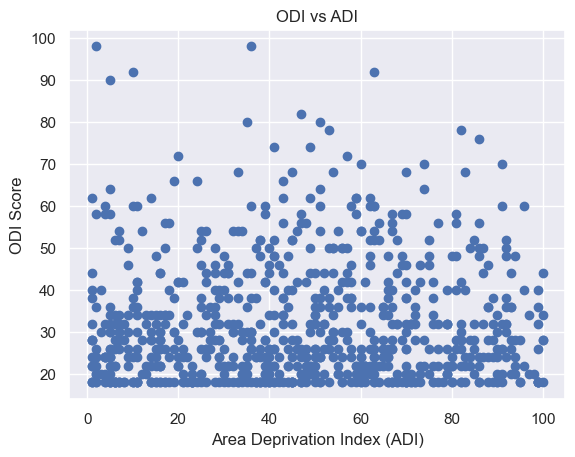

In [16]:
fig, ax = plt.subplots()
ax.plot(odi_quality_df['adi_score'], odi_quality_df['odi_final'], 'o')
ax.set_ylabel('ODI Score')
ax.set_xlabel('Area Deprivation Index (ADI)')
ax.set_title("ODI vs ADI")
plt.show()